# Image Processing SS 20 - Assignment - 07

### Deadline is 10.6.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [10]:
# display the plots inside the notebook
%matplotlib inline

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray
from math import e,pi,sqrt
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

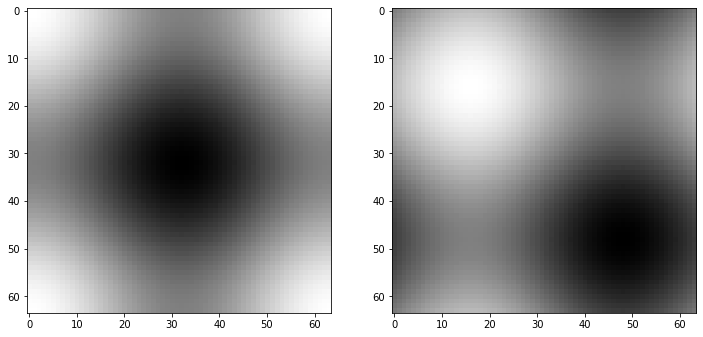

In [12]:
# Playground to get some intuition for 2d fourier transformation
ft = np.zeros((64,64))

# set some random coefficents and see what happens
ft[1, 0] = 1
ft[0, 1] = 1

#ft[10, 10] = 1

plt.subplot(121)
plt.imshow(np.real(numpy_ifft2(ft)), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(numpy_ifft2(ft)), cmap='gray')
plt.show()

# Exercise 1 - 2D DFT - 2 Points
Implement the 2D Discrete Fourier Transformation with [Matrix Multiplication](https://en.wikipedia.org/wiki/DFT_matrix). You can use your code from the last assignment to compute the dct matrix.

In [13]:
def dft_matrix(n):
    """
    Returns the Discrete Fourier Transformation Matrix of order `n`.
    """
    w  =  e ** ((-2j *pi)/n)
    matrix = (1/n**(1/2)) * np.fromfunction(lambda i,k: (w **(i*k)), (n ,n))
    return matrix

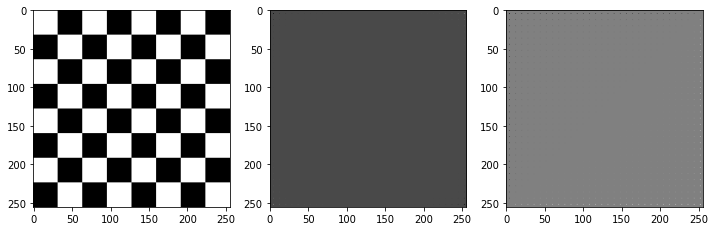

In [44]:
def dft2d(img):
    """
    Returns the 2d discrete fourier transformation
    """
    matrix = dft_matrix(img.shape[0])
    result = matrix @ img @ matrix
    return result

def inv_dft2d(x):
    """
    Returns the 2d inverse discrete fourier transformation
    """
    matrix = dft_matrix(x.shape[0])
    result = np.conjugate(matrix) @ x @ np.conjugate(matrix)
    return numpy_ifft2(x)


def chess_board(n=8, field_size=32):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

plt.subplot(131)
plt.imshow(abs(inv_dft2d(dft2d(chess_board()))), cmap='gray')
plt.subplot(132)
plt.imshow(np.real(dft2d(chess_board())), cmap='gray')
plt.subplot(133)
plt.imshow(np.imag(dft2d(chess_board())), cmap='gray')
plt.show()

# Exercise 2 - High and Low Pass filter with the 2D fourier transformation - 3 Points

In [119]:
def high_pass(img_ft, n):
    """Removes the high frequencies and let low frequencies pass"""
    ft = img_ft.copy()
    ft[:n, :n] = 0
    ft[-n:, :n] = 0
    ft[-n:, -n:] = 0
    ft[:n, -n:] = 0
    return ft

def low_pass(img_ft, n):
    """Removes the low frequencies and let high frequencies pass"""
    ft = img_ft.copy()
    ft[n:-n, :] = 0
    ft[:, n:-n] = 0
    return ft
    
def band_pass(img_ft, low, high):
    """Only preserve the frequencies between low and high"""
    result = low_pass(img_ft, high)
    result = high_pass(result, low)    
    return result
    
def inv_dft_and_plot(img_ft):
    plt.imshow(np.real(inv_dft2d(img_ft)), cmap='gray')
    plt.show()

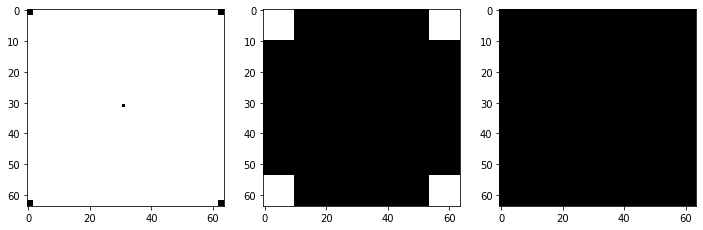

In [124]:
""" for verification """
img2 = np.ones((64,64))
img2[31, 31] = 0

plt.subplot(131)
plt.imshow(high_pass(img2, 2), cmap="gray")
plt.subplot(132)
plt.imshow(low_pass(img2, 10), cmap="gray")
plt.subplot(133)
plt.imshow(band_pass(img2, 10, 2), cmap="gray")

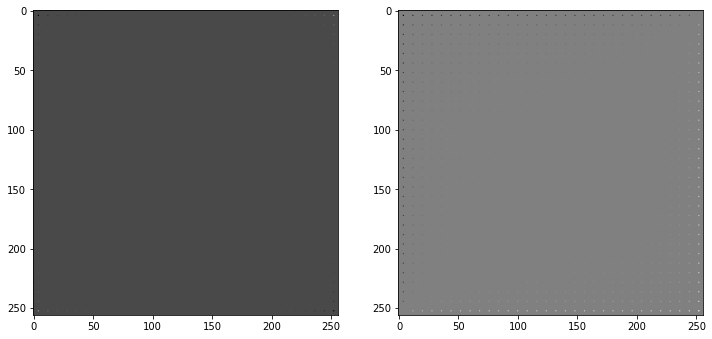

In [114]:
chess_board_ft = dft2d(chess_board())

# display frequency domain of the chess_board
plt.subplot(121)
plt.imshow(np.real(chess_board_ft), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(chess_board_ft), cmap='gray')
plt.show()

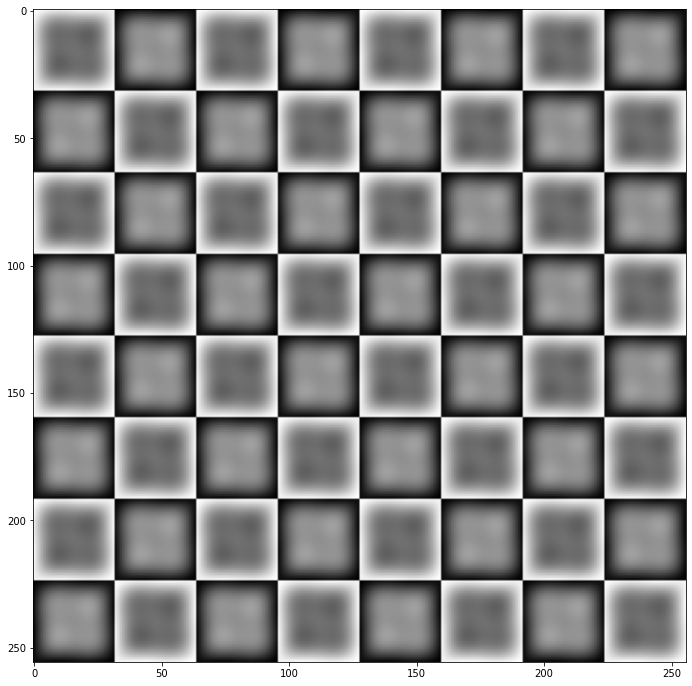

In [115]:
# remove the low frequencies of the chess board
chess_high_feq = high_pass(chess_board_ft, 12)
inv_dft_and_plot(chess_high_feq)

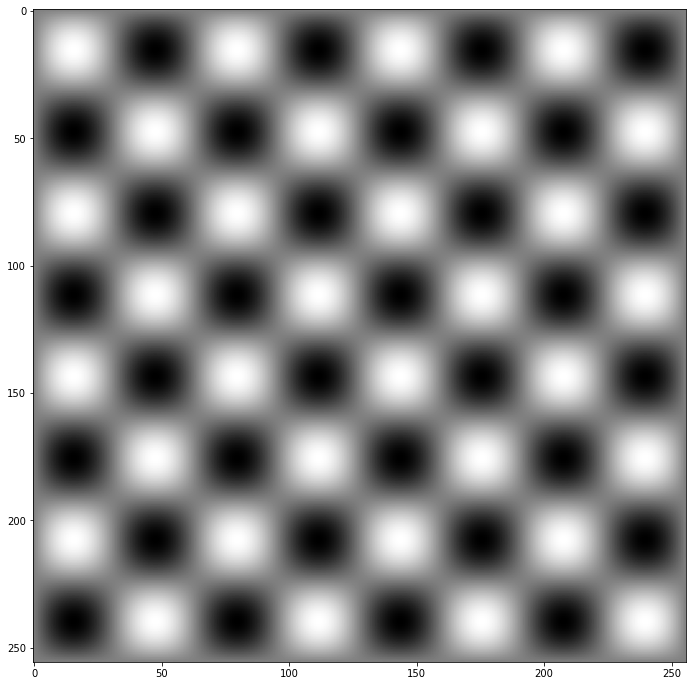

In [116]:
# remove the high frequencies of the chess board
chess_low_feq = low_pass(chess_board_ft, 10)
inv_dft_and_plot(chess_low_feq)

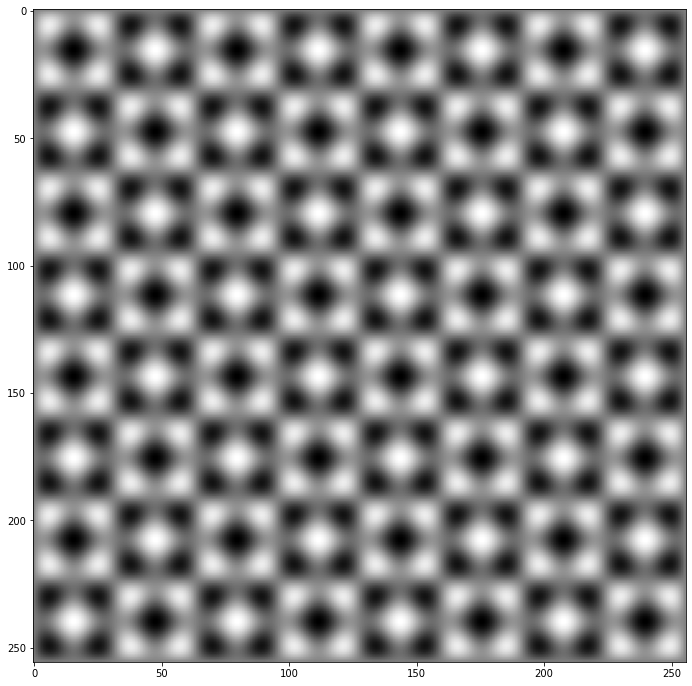

In [123]:
# remove the high frequencies of the chess board
chess_medium_feq = band_pass(chess_board_ft, 5, 15)
inv_dft_and_plot(chess_medium_feq)

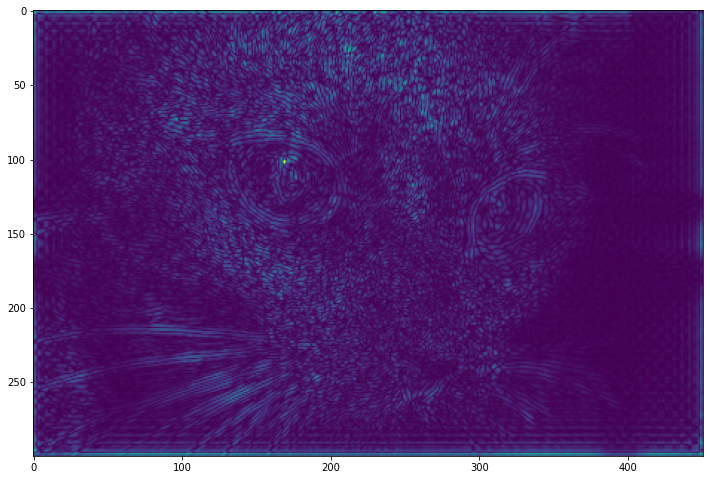

In [131]:
img = rgb2gray(chelsea() / 255)
# filter all frequencies corresponding to the coefficients between 48 and 128.
# your code here

result = np.zeros((451,451))
result[:img.shape[0], :img.shape[1]] = img
ft = dft2d(result)
ft_band = band_pass(ft,48,128)

inv_pic = inv_dft2d(ft_band)

plt.imshow(np.abs(inv_pic[:img.shape[0], :img.shape[1]]))
plt.show()


# inv_dft_and_plot()

# Exercise 3 - FFT - 5 Points

Implement the fast fourier transformation. 
Use the [Cooley-Tukey](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) algorithm.

In [173]:
def fft(img):
    """
    Computes the fast fourier transformation of x.
    """

    #extend the picture to the power of 2**x
    maxs = np.amax(img.shape)
    power = np.where(np.fromfunction(lambda i: (2**i), (15,))  > maxs)[0][0]
    
    value = 2**power
    img_extended = np.zeros((value,value))
    img_extended[:img.shape[0], :img.shape[1]] = img

    return fft_recursion(img_extended, value)

def fft_recursion(img, power):
    n = img.shape[0]
    y = np.zeros_like(img)
    if power <= 1:
        return dft_matrix(img)
    else:
        w_n  =  e ** ((-2j *pi)/n)
        w = 1
        a_even = img[::2]
        a_odd = img[1::2]
        y_even = fft_recursion(a_even, power // 2)
        y_odd = fft_recursion(a_odd, power // 2)
        for i in range(n/2):
            y[i] = y_even[i] + w * y_odd[j]
            y[j+(n/2)] = y_even[j] - w * y_odd[j]
            w = w * w_n
        return y

        
#http://people.scs.carleton.ca/~maheshwa/courses/5703COMP/16Fall/FFT_Report.pdfto   
#https://towardsdatascience.com/fast-fourier-transform-937926e591cb


In [174]:
img = rgb2gray(chelsea() / 255)
fft_img = fft(img)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
plt.subplot(121)
plt.imshow(np.real(fft_img))
plt.subplot(122)
plt.imshow(np.imag(fft_img))
plt.show()